In [23]:
import decimal
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np

In [25]:
class APECalculator():

    def __init__(self, virtual_eth_reserve, virtual_token_reserve, reserve_ratio, slope):
        self.virtual_eth_reserve = Decimal(virtual_eth_reserve)
        self.virtual_token_reserve = Decimal(virtual_token_reserve)
        self.reserve_ratio = Decimal(reserve_ratio)
        self.slope = Decimal(slope)
        decimal.getcontext().prec = 28

    def calculate_purchase_return(self, supply, connector_balance, connector_weight, deposit_amount, slope):
        try:
            supply_dec = Decimal(supply) * self.DEC
            connector_balance_dec = Decimal(connector_balance) * self.DEC
            connector_weight_dec = Decimal(connector_weight)
            deposit_amount_dec = Decimal(deposit_amount) * self.DEC
            slope_dec = Decimal(slope)

            if supply_dec < 0 or connector_balance_dec <= 0 or connector_weight_dec <= 0 or connector_weight_dec > self.MAX_WEIGHT or deposit_amount_dec == 0:
                return '0'
                
            if supply_dec == 0:
                purchase_return = (deposit_amount_dec / (deposit_amount_dec * slope_dec))**connector_weight_dec
                return self.format_decimal(purchase_return / self.DEC)

            if connector_weight_dec == self.MAX_WEIGHT:
                return self.format_decimal(supply_dec * deposit_amount_dec // connector_balance_dec / self.DEC)

            base = (deposit_amount_dec + connector_balance_dec) / connector_balance_dec
            exp = connector_weight_dec / self.MAX_WEIGHT
            result = base ** exp
            purchase_return = (supply_dec * result - supply_dec).to_integral_exact(rounding=decimal.ROUND_FLOOR) - 1000

            return self.format_decimal(purchase_return / self.DEC)
        except:
            return '0'

    def estimate_eth_in_for_exact_tokens_out(self, supply, connector_balance, connector_weight, token_amount_out, slope):
        try:
            supply_dec = Decimal(supply) * self.DEC
            connector_balance_dec = Decimal(connector_balance) * self.DEC
            connector_weight_dec = Decimal(connector_weight)
            token_amount_out_dec = Decimal(token_amount_out) * self.DEC

            if supply_dec < 0 or connector_balance_dec <= 0 or connector_weight_dec <= 0 or connector_weight_dec > self.MAX_WEIGHT or token_amount_out_dec == 0:
                return '0'
                                
            if supply_dec == 0:
                estimated_eth_in = connector_weight_dec * slope_dec * (supply_dec**(Decimal(1)/connector_weight_dec))
                return self.format_decimal(estimated_eth_in / self.DEC)

            if connector_weight_dec == self.MAX_WEIGHT:
                return self.format_decimal(token_amount_out_dec * connector_balance_dec / supply_dec / self.DEC)

            base = (token_amount_out_dec + supply_dec) / supply_dec
            exp = self.MAX_WEIGHT / connector_weight_dec
            result = base ** exp
            estimated_eth_in = connector_balance_dec * result - connector_balance_dec + 1000

            return self.format_decimal(estimated_eth_in / self.DEC)
        except:
            return '0'

    def calculate_tokens_out_for_exact_eth_in_from_scratch(self, eth_amount_in):
        # return self.calculate_purchase_return(self, virtual_token_reserve, virtual_eth_reserve, reserve_ratio, eth_amount_in)
        return self.calculate_purchase_return(self.virtual_token_reserve, self.virtual_eth_reserve, self.reserve_ratio, eth_amount_in, self.slope)

    def calculate_eth_in_for_exact_tokens_in_from_scratch(self, token_amount_out):
        # return self.estimate_eth_in_for_exact_tokens_out(self, virtual_token_reserve, virtual_eth_reserve, reserve_ratio, token_amount_out):
        return self.estimate_eth_in_for_exact_tokens_out(self.virtual_token_reserve, self.virtual_eth_reserve, self.reserve_ratio, token_amount_out, self.slope)


In [27]:

class UniswapCalculator():

    def __init__(self, virtual_eth_reserve, virtual_token_reserve):
        self.virtual_eth_reserve = Decimal(virtual_eth_reserve)
        self.virtual_token_reserve = Decimal(virtual_token_reserve)
        decimal.getcontext().prec = 28

    def calculate_purchase_return(self, eth_in, eth_reserve, token_reserve):
        try:
            if Decimal(eth_in) == 0 or Decimal(eth_reserve) == 0 or Decimal(token_reserve) == 0:
                return '0'

            eth_in_wei = self.to_wei(eth_in)
            eth_reserve_wei = self.to_wei(eth_reserve)
            token_reserve_wei = self.to_wei(token_reserve)

            token_out = (token_reserve_wei * eth_in_wei) // (eth_reserve_wei + eth_in_wei)

            return self.format_decimal(self.from_wei(token_out))
        except:
            return '0'


    def estimate_eth_in_for_exact_tokens_out(self, tokens_out, eth_reserve, token_reserve):
        try:
            if Decimal(tokens_out) == 0 or Decimal(eth_reserve) == 0 or Decimal(token_reserve) == 0:
                return '0'

            tokens_out_wei = Decimal(tokens_out) * self.DEC
            eth_reserve_wei = Decimal(eth_reserve) * self.DEC
            token_reserve_wei = Decimal(token_reserve) * self.DEC

            eth_in = (eth_reserve_wei * tokens_out_wei) / (token_reserve_wei - tokens_out_wei) + 1

            return self.format_decimal(eth_in / self.DEC)
        except:
            return '0'

    def calculate_tokens_out_for_exact_eth_in_from_scratch(self, eth_amount_in):
        # return self.calculate_purchase_return(self, eth_amount_in, virtual_eth_reserve, virtual_token_reserve)
        return self.calculate_purchase_return(eth_amount_in, self.virtual_eth_reserve, self.virtual_token_reserve)

    def calculate_eth_in_for_exact_tokens_in_from_scratch(self, token_amount_out):
        # return self.estimate_eth_in_for_exact_tokens_out(self, token_amount_out, virtual_eth_reserve, virtual_token_reserve)
        return self.estimate_eth_in_for_exact_tokens_out(token_amount_out, self.virtual_eth_reserve, self.virtual_token_reserve)


In [29]:
ape_virtual_eth_reserve = "0.000000000008571428"
ape_virtual_token_reserve = "1000"
ape_reserve_ratio = "500000"
slope = 1.5012548367*10**(-28)

uniswap_virtual_eth_reserve = "1.05"
uniswap_virtual_token_reserve = "1000000000"


# Usage example
ape_calculator = APECalculator(ape_virtual_eth_reserve, ape_virtual_token_reserve, ape_reserve_ratio, slope)
uniswap_calculator = UniswapCalculator(uniswap_virtual_eth_reserve, uniswap_virtual_token_reserve)


In [31]:
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal

class TokenomicsCharts:
    def __init__(self, ape_calculator, uniswap_calculator):
        self.ape_calculator = ape_calculator
        self.uniswap_calculator = uniswap_calculator

    def compare_purchase_returns(self, eth_in_range):
        ape_returns = []
        uniswap_returns = []
        for eth_in in eth_in_range:
            ape_return = Decimal(self.ape_calculator.calculate_tokens_out_for_exact_eth_in_from_scratch(str(eth_in)))
            uniswap_return = Decimal(self.uniswap_calculator.calculate_tokens_out_for_exact_eth_in_from_scratch(str(eth_in)))
            
            ape_returns.append(ape_return)
            uniswap_returns.append(uniswap_return)
        return ape_returns, uniswap_returns

    def plot_comparison(self, x_values, y1_values, y2_values, title, xlabel, ylabel):
        plt.figure(figsize=(12, 6))
        plt.plot(x_values, y1_values, label='APE Formula')
        plt.plot(x_values, y2_values, label='Uniswap Formula')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_bar_comparison(self, eth_values, ape_returns, uniswap_returns):
        x = np.arange(len(eth_values))
        width = 0.35
        fig, ax = plt.subplots(figsize=(12, 6))
        rects1 = ax.bar(x - width/2, ape_returns, width, label='APE Formula')
        rects2 = ax.bar(x + width/2, uniswap_returns, width, label='Uniswap Formula')
        ax.set_ylabel('Tokens Out')
        ax.set_xlabel('ETH In')
        ax.set_title('Comparison of Token Returns for Specific ETH Inputs')
        ax.set_xticks(x)
        ax.set_xticklabels(eth_values)
        ax.legend()
        ax.bar_label(rects1, padding=3, rotation=90)
        ax.bar_label(rects2, padding=3, rotation=90)
        fig.tight_layout()
        plt.show()

    def plot_max_height_bar_comparison(self, eth_values, ape_returns, uniswap_returns):
        fig, ax = plt.subplots(figsize=(12, 8))
        ape_color = 'skyblue'
        uniswap_color = 'lightgreen'
        ape_max = max(ape_returns)
        uniswap_max = max(uniswap_returns)
        bar_width = 0.35
        ax.bar(0, ape_max, width=bar_width, color=ape_color, label='APE Formula')
        ax.bar(1, uniswap_max, width=bar_width, color=uniswap_color, label='Uniswap Formula')
        
        for i, (eth, ape_return, uniswap_return) in enumerate(zip(eth_values, ape_returns, uniswap_returns)):
            ax.hlines(y=ape_return, xmin=-0.15, xmax=0.15, color='navy', linestyle='-')
            ax.text(-0.2, ape_return, f'{eth}: {ape_return:.2f}', ha='right', va='center')
            ax.hlines(y=uniswap_return, xmin=0.85, xmax=1.15, color='darkgreen', linestyle='-')
            ax.text(1.2, uniswap_return, f'{eth}: {uniswap_return:.2f}', ha='left', va='center')
        
        ax.set_ylabel('Tokens Out', fontsize=12)
        ax.set_title('Comparison of Token Returns for Specific ETH Inputs', fontsize=14)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['APE Formula', 'Uniswap Formula'])
        ax.set_ylim(bottom=0)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    def plot_eth_estimate_comparison(self, token_amounts, ape_estimates, uniswap_estimates):
        fig, ax = plt.subplots(figsize=(12, 8))
        x = range(len(token_amounts))
        width = 0.35
        ax.bar([i - width/2 for i in x], ape_estimates, width, label='APE Formula', color='skyblue')
        ax.bar([i + width/2 for i in x], uniswap_estimates, width, label='Uniswap Formula', color='lightgreen')
        ax.set_ylabel('Estimated ETH In', fontsize=12)
        ax.set_xlabel('Tokens Out (in millions)', fontsize=12)
        ax.set_title('Estimated ETH Input for Specific Token Output Amounts', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels([f'{amount/1000000}M' for amount in token_amounts])
        ax.legend()
        
        for i, v in enumerate(ape_estimates):
            ax.text(i - width/2, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)
        for i, v in enumerate(uniswap_estimates):
            ax.text(i + width/2, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)
        
        plt.tight_layout()
        plt.show()

    def generate_chart1(self):
        eth_in_range = [Decimal('0.01') + Decimal('0.01') * i for i in range(420)]  # 0.01 to 4.2 ETH
        ape_purchase_returns, uniswap_purchase_returns = self.compare_purchase_returns(eth_in_range)
        self.plot_comparison(
            eth_in_range, ape_purchase_returns, uniswap_purchase_returns,
            "Purchase Return Comparison", "ETH In", "Tokens Out"
        )

    def generate_chart2(self):
        eth_values = ['1 ETH', '2 ETH', '3 ETH', '4 ETH', '4.2 ETH']
        specific_eth_inputs = [1, 2, 3, 4, 4.2]
        ape_specific_returns = [Decimal(self.ape_calculator.calculate_tokens_out_for_exact_eth_in_from_scratch(str(eth))) for eth in specific_eth_inputs]
        uniswap_specific_returns = [Decimal(self.uniswap_calculator.calculate_tokens_out_for_exact_eth_in_from_scratch(str(eth))) for eth in specific_eth_inputs]
        self.plot_max_height_bar_comparison(eth_values, ape_specific_returns, uniswap_specific_returns)
        
        print("Buy Returns:")
        for eth, ape_return, uniswap_return in zip(eth_values, ape_specific_returns, uniswap_specific_returns):
            print(f"{eth}:")
            print(f"  APE: {ape_return:.2f}")
            print(f"  Uniswap: {uniswap_return:.2f}")
            print()

    def generate_chart3(self):
        eth_values = ['1 ETH', '2 ETH', '3 ETH', '4 ETH', '4.2 ETH']
        specific_eth_inputs = [1, 2, 3, 4, 4.2]
        ape_specific_returns = [Decimal(self.ape_calculator.calculate_tokens_out_for_exact_eth_in_from_scratch(str(eth))) for eth in specific_eth_inputs]
        uniswap_specific_returns = [Decimal(self.uniswap_calculator.calculate_tokens_out_for_exact_eth_in_from_scratch(str(eth))) for eth in specific_eth_inputs]
        self.plot_bar_comparison(eth_values, ape_specific_returns, uniswap_specific_returns)
        
        print("Sample Purchase Returns:")
        for eth in specific_eth_inputs:
            print(f"ETH In: {eth}")
            print(f"APE: {self.ape_calculator.calculate_tokens_out_for_exact_eth_in_from_scratch(str(eth))}")
            print(f"Uniswap: {self.uniswap_calculator.calculate_tokens_out_for_exact_eth_in_from_scratch(str(eth))}")
            print()
            
    def generate_chart4(self):
        token_amounts = [100000000 * i for i in range(1, 9)]  # 100M to 800M
        ape_estimates = [Decimal(self.ape_calculator.calculate_eth_in_for_exact_tokens_in_from_scratch(str(amount))) for amount in token_amounts]
        uniswap_estimates = [Decimal(self.uniswap_calculator.calculate_eth_in_for_exact_tokens_in_from_scratch(str(amount))) for amount in token_amounts]
        self.plot_eth_estimate_comparison(token_amounts, ape_estimates, uniswap_estimates)
        
        print("Estimated ETH Input for Token Output:")
        for amount, ape_estimate, uniswap_estimate in zip(token_amounts, ape_estimates, uniswap_estimates):
            print(f"{amount/1000000}M tokens out:")
            print(f"  APE: {ape_estimate:.2f} ETH")
            print(f"  Uniswap: {uniswap_estimate:.2f} ETH")
            print()

charts = TokenomicsCharts(ape_calculator, uniswap_calculator)


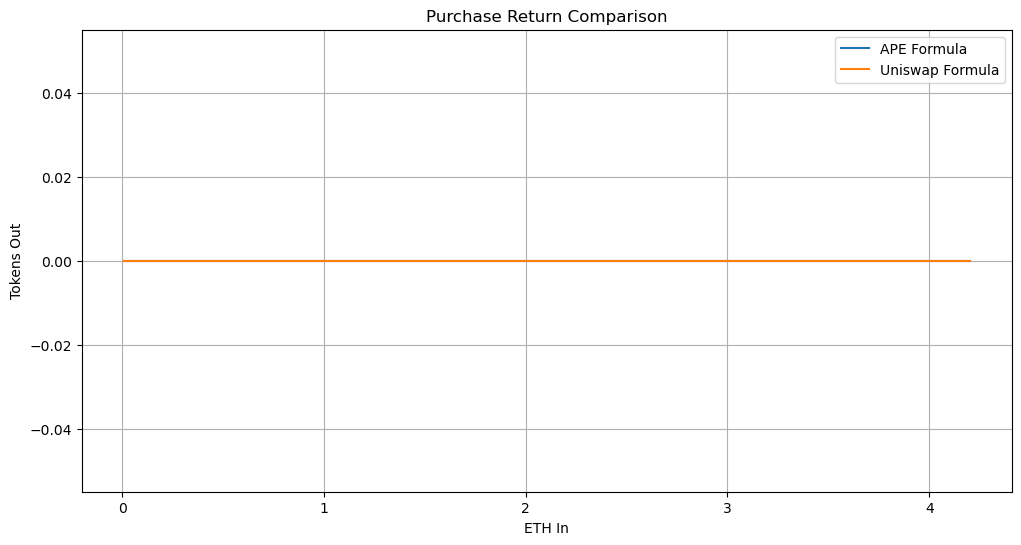

In [33]:
charts.generate_chart1()

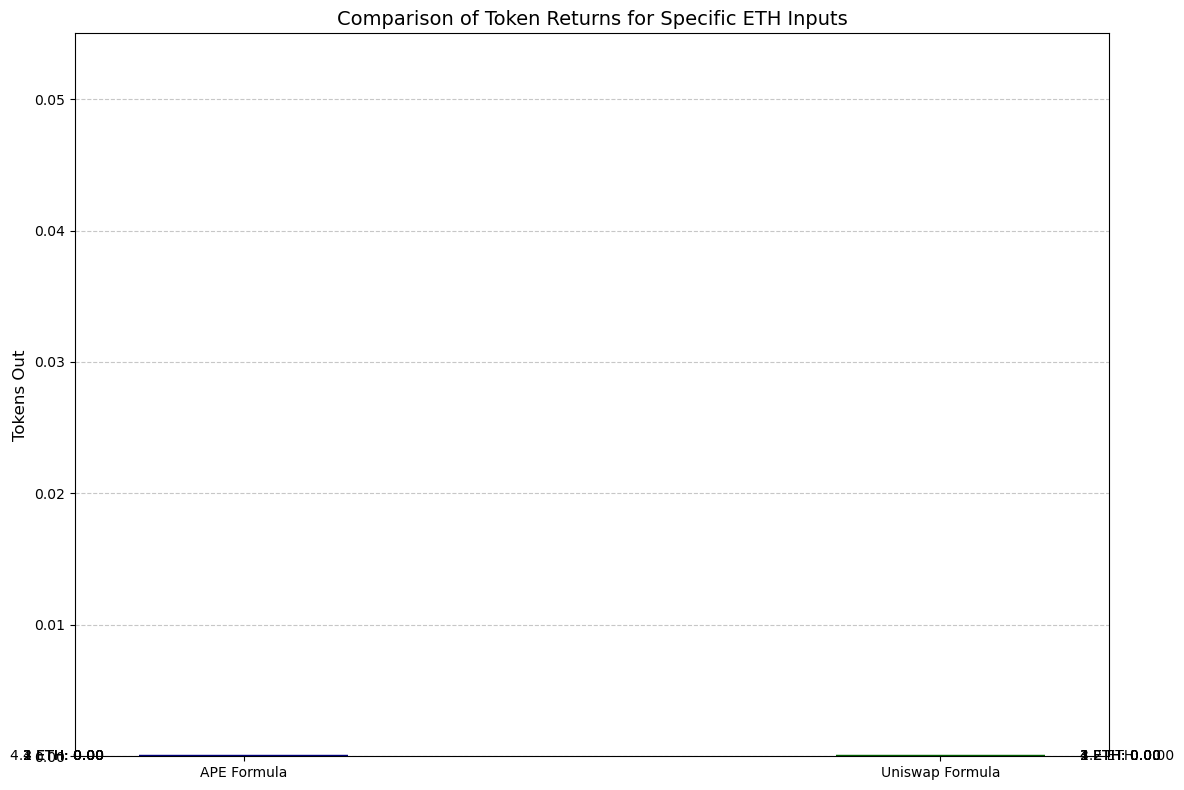

Buy Returns:
1 ETH:
  APE: 0.00
  Uniswap: 0.00

2 ETH:
  APE: 0.00
  Uniswap: 0.00

3 ETH:
  APE: 0.00
  Uniswap: 0.00

4 ETH:
  APE: 0.00
  Uniswap: 0.00

4.2 ETH:
  APE: 0.00
  Uniswap: 0.00



In [35]:
charts.generate_chart2()

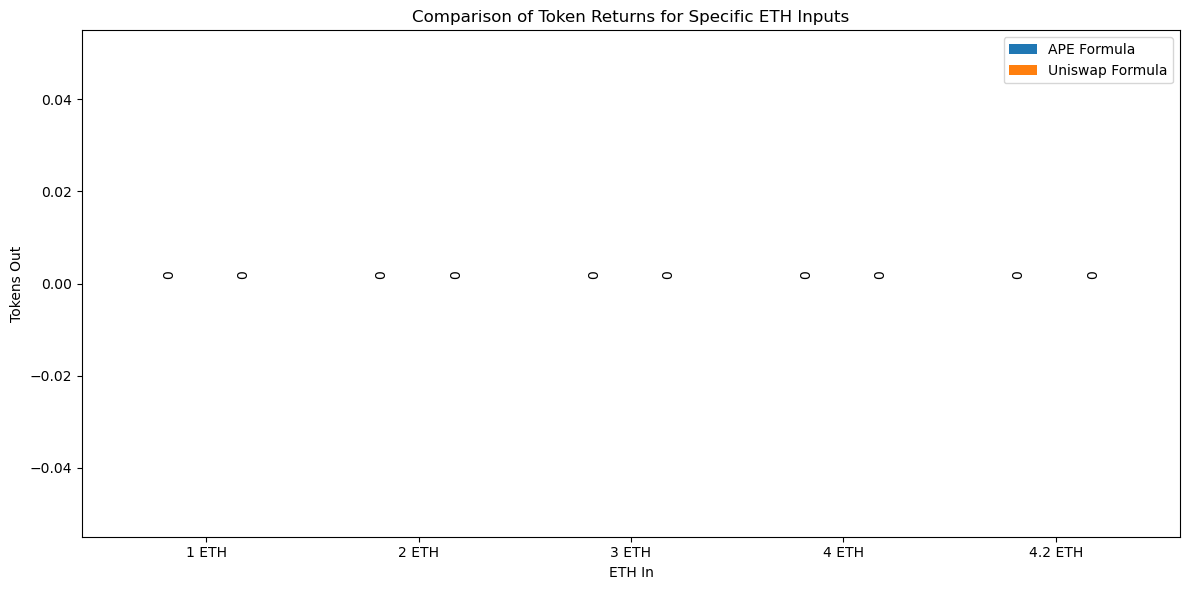

Sample Purchase Returns:
ETH In: 1
APE: 0
Uniswap: 0

ETH In: 2
APE: 0
Uniswap: 0

ETH In: 3
APE: 0
Uniswap: 0

ETH In: 4
APE: 0
Uniswap: 0

ETH In: 4.2
APE: 0
Uniswap: 0



In [37]:
charts.generate_chart3()

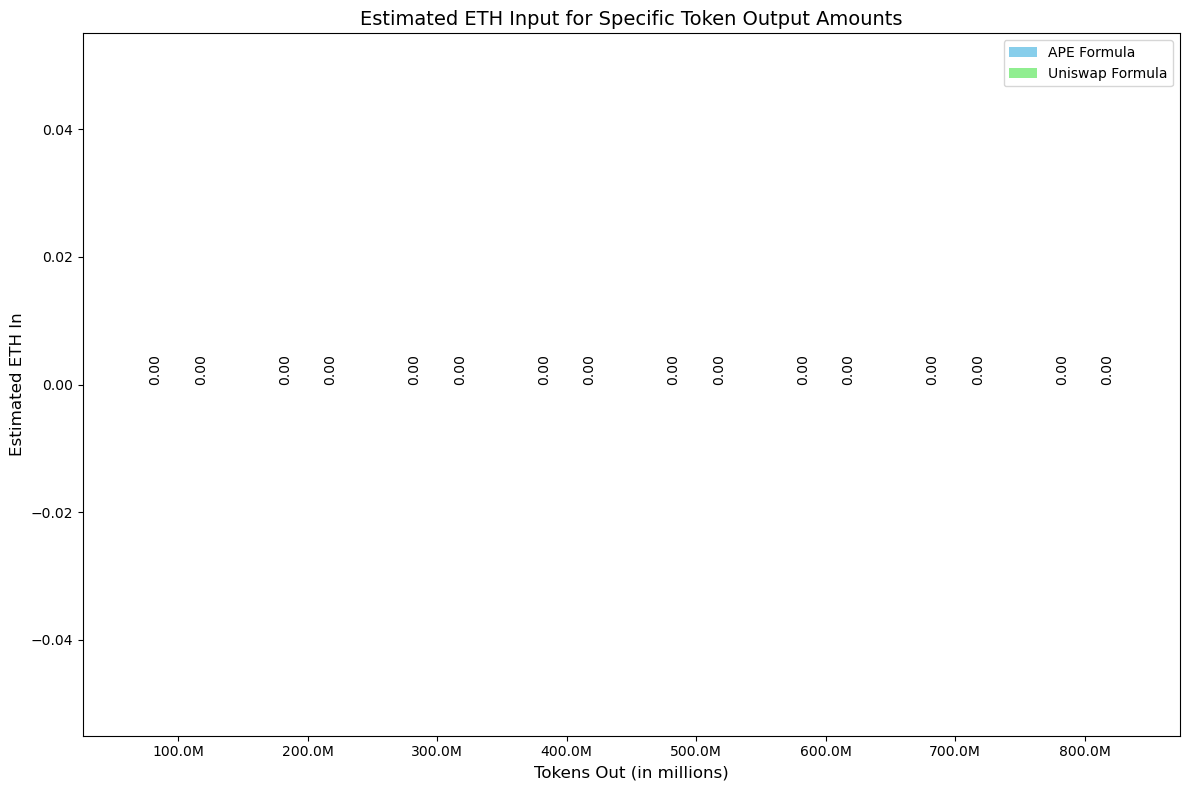

Estimated ETH Input for Token Output:
100.0M tokens out:
  APE: 0.00 ETH
  Uniswap: 0.00 ETH

200.0M tokens out:
  APE: 0.00 ETH
  Uniswap: 0.00 ETH

300.0M tokens out:
  APE: 0.00 ETH
  Uniswap: 0.00 ETH

400.0M tokens out:
  APE: 0.00 ETH
  Uniswap: 0.00 ETH

500.0M tokens out:
  APE: 0.00 ETH
  Uniswap: 0.00 ETH

600.0M tokens out:
  APE: 0.00 ETH
  Uniswap: 0.00 ETH

700.0M tokens out:
  APE: 0.00 ETH
  Uniswap: 0.00 ETH

800.0M tokens out:
  APE: 0.00 ETH
  Uniswap: 0.00 ETH



In [39]:
charts.generate_chart4()